# Introduction of dataset

In [1]:
import os, sys
import numpy as np
import h5py
import sigpy as sp
import matplotlib.pyplot as plt
import pathlib
plt.rcParams["figure.figsize"] = (10,10)

import skimage
from fastmri.evaluate import ssim

import sigpy.plot as pl
from torch.utils.data import DataLoader, Dataset
import torch

In [2]:
# location of the dset : /mnt/dense/kanghyun/summer_dset
# There are 4 datasets (different contrast or anatomy)
print('Datasets: ',os.listdir('/mnt/dense/kanghyun/summer_dset'))
print('Inside Train directory: ',os.listdir('/mnt/dense/kanghyun/summer_dset/div_sagittal_t2/Train'))
print('Inside Train directory: ',os.listdir('/mnt/dense/kanghyun/summer_dset/div_axial_t2/Train'))

basedir = '/mnt/dense/kanghyun/summer_dset/div_coronal_pd_fs/Train' # make this as base directory and move on

Datasets:  ['div_coronal_pd', 'div_coronal_pd_fs', 'div_axial_t2', 'div_sagittal_t2']
Inside Train directory:  ['rawdata_20.h5', 'rawdata_14.h5', 'rawdata_10.h5', 'rawdata_11.h5', 'rawdata_15.h5', 'rawdata_5.h5', 'rawdata_1.h5', 'rawdata_18.h5', 'rawdata_2.h5', 'rawdata_16.h5', 'rawdata_8.h5', 'rawdata_17.h5', 'rawdata_9.h5', 'rawdata_13.h5']
Inside Train directory:  ['rawdata_20.h5', 'rawdata_14.h5', 'rawdata_10.h5', 'rawdata_11.h5', 'rawdata_15.h5', 'rawdata_5.h5', 'rawdata_1.h5', 'rawdata_18.h5', 'rawdata_2.h5', 'rawdata_16.h5', 'rawdata_8.h5', 'rawdata_17.h5', 'rawdata_9.h5', 'rawdata_13.h5']


In [3]:
# Reading h5 file
# h5 file is a format to store a large size array, which can not be accessed fully with RAM
with h5py.File(os.path.join(basedir, 'rawdata_14.h5'),'r') as hr:
    print(list(hr.keys())) # What is inside the h5 file
    kspace = hr['kspace'][:] # saving the array to numpy (RAM)
    esp_maps = hr['esp_maps'][:]

print(kspace.shape, esp_maps.shape) # order (nslices, nCoils, nX, nY)
# Note that nX is much bigger than nY (because for Cartesian, sampling in nX doesn't affect overall scan time)
# Scan time for the dataset : TR x nY. TR affects image contrast (small TR -> T1 weighting, large TR -> PD / T2 weighting)

['esp_maps', 'kspace', 'sens']
(35, 15, 577, 332) (35, 15, 577, 332)


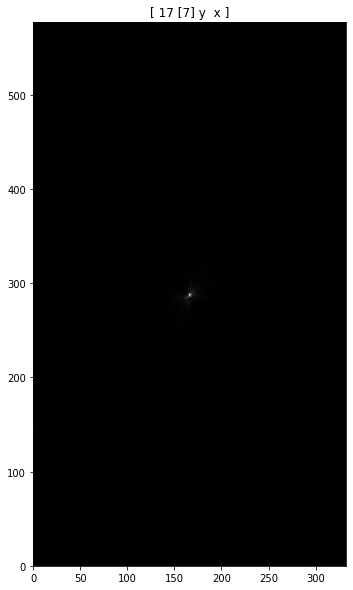

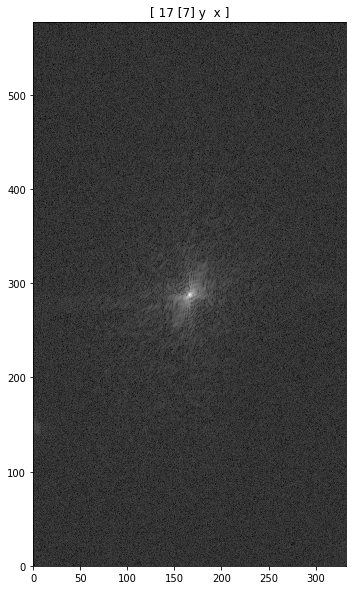

In [4]:
# Now let's look at the kspace

pl.ImagePlot(kspace) # Visualization of kspace in original space
pl.ImagePlot(kspace**0.2) # Visualization of kspace in approx. log scale (much better to visualize)

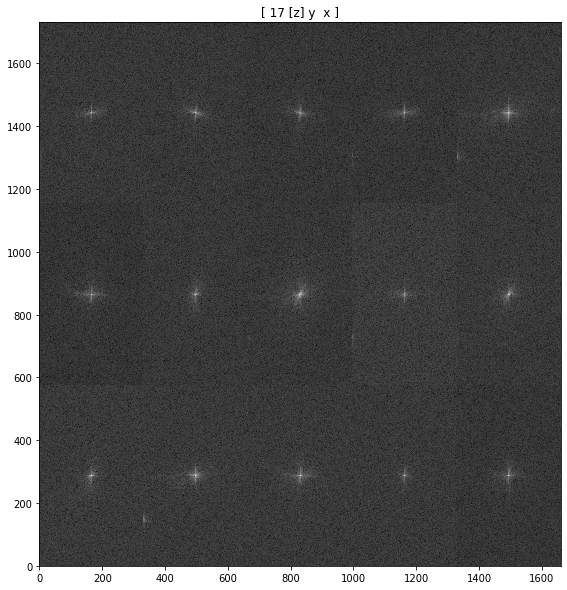

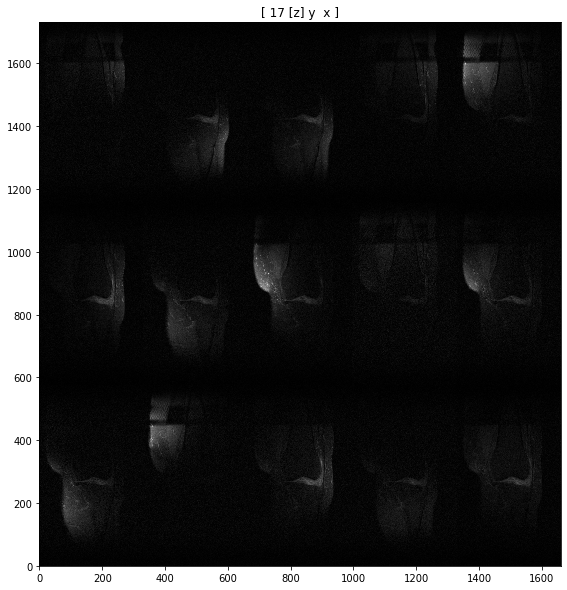

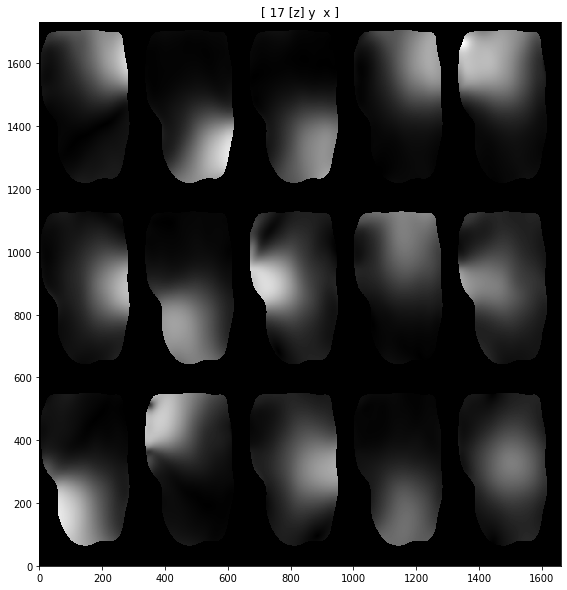

In [5]:
pl.ImagePlot(kspace**0.2, z=1) # Let's look at multi-coil kspace, z=1 means visualizing grid on the axis =1
# ith kspace corresponds to fft(true_image * coil_sensitivity_i) 

im_coil = sp.ifft(kspace, axes=(-1,-2)) # Let's ifft kspace to get coil image

pl.ImagePlot(im_coil, z=1) # Here now you can see each images correspond to true_image * coil_esp_mapsitivity
esp_maps = np.complex64(esp_maps)
pl.ImagePlot(esp_maps, z=1) # Look at the esp_mapsitivity map

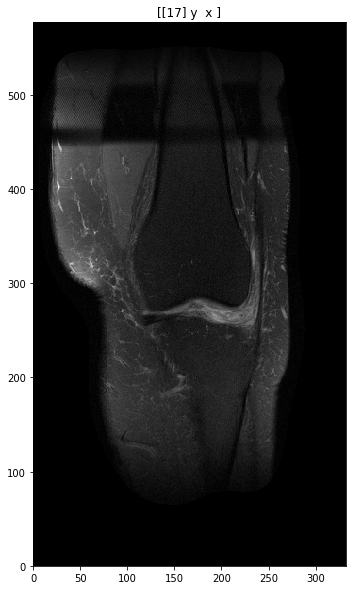

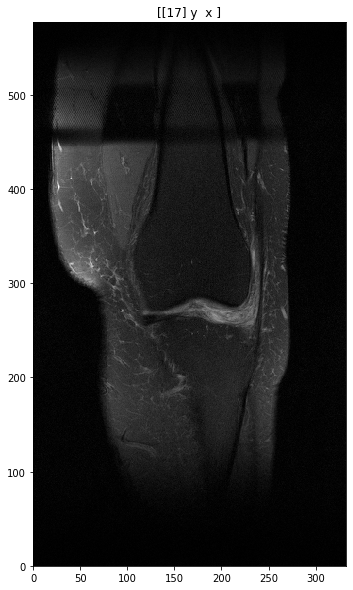

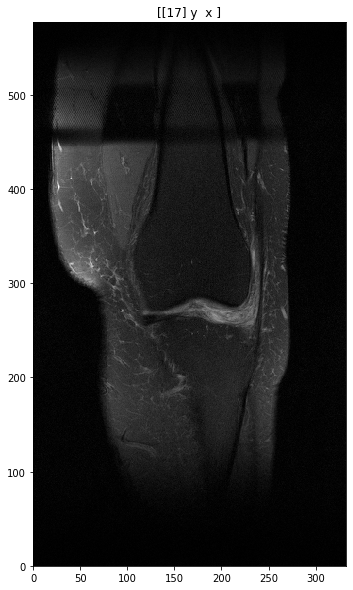

In [14]:
# # there are mainly two ways to combine the multi-coil images
# # 1. coils are designed to be symetrically distributed around the object, so usually root-sum-of squares can get sufficient estimates

# im_rss = np.sqrt((im_coil * np.conj(im_coil)).sum(axis=1)) # np.conj because MR images are complex
# print('RSS combined', im_rss.shape)
# pl.ImagePlot(im_rss) 

# 2. Coil esp_mapsitivity maps can be scanned or estimated (i.e. ESPIRIT, JSENSE, etc.) and used to combine  

im_esp_map = np.sum(im_coil * np.conj(esp_maps), axis=1)
pl.ImagePlot(im_esp_map) 

# (optional) Refer to https://users.fmrib.ox.ac.uk/~mchiew/docs/SENSE_tutorial.html, It's in MATLAB but covers SENSE reconstruction, gfactor maps

# Simulation of Undersampled acquisition

In [ ]:
from fastmri.data import subsample, transforms

R = 4
mask_func = subsample.EquispacedMaskFunc(
                            center_fractions=[0.06],
                            accelerations=[R]) # This function generates an equispaced sampling mask generator
# help(subsample.EquispacedMaskFunc) # This is the description (uncomment this)

mask = mask_func(list(kspace.shape) + [1])[...,0] # trick because undersampling is in axis -1
mask = mask.numpy()
print(mask.shape)

kspace_us = kspace * mask 
pl.ImagePlot(kspace_us ** 0.2)

In [ ]:
im_us_coil = sp.ifft(kspace_us, axes=(-1,-2)) # Let's try to reconstruct with the same process
im_us_esp_mapse = np.sum(im_us_coil * np.conj(esp_maps), axis=1)

pl.ImagePlot(im_us_esp_mapse) # Now we get a weird aliased image

# Typically SENSE/GRAPPA (Parallel Imaging) method can recover x2 accelerations, 
# Parallel Imaging + Compressed Sensing (PI-CS) can recover x2-4 accelerations
# Deep Learning can recover up to x4-6 accelerations
# The final objective will be (im_us_esp_mapse + kspace_us + esp_mapsivitiy) ==> Deep Learning Recon ==> im_esp_mapse


In [ ]:
# For demonstration, let's look at PI-CS reconstruction method
# PI-CS method performs better with random-sampling so the result may be worse than it actually is
# Refer to https://github.com/mikgroup/sigpy-mri-tutorial/blob/master/03-building-an-l1-wavelet-recon-app.ipynb

PI-CS solves the following minimization problem:
$$\min_x \frac{1}{2} \| \underbrace{P F S }_{A} x - y \|_2^2 + \lambda \|W x \|_1$$
Where P is the sampling operator, F is the Fourier Transform operator, S is the esp_mapsitivity map operator, W is the wavelet transform operator


In [ ]:
from sigpy.mri.app import L1WaveletRecon

y = kspace_us[17] # select 17th slice
mps = esp_maps[17]

img = L1WaveletRecon(y, mps, lamda = 0.05).run() # lamda is the regularizaition

In [ ]:
lambda_ = 0.05
pl.ImagePlot(img, title = f'lambda = {lambda_}') # This is the reconstructed result

In [ ]:
# Task to do : 1. How does the reconstructed image looks for different lambda values
# 2. What is the quantitative score (nRMSE, SSIM) for the above image? Can you calculate mean + std for the score for the images in Test 
# Please try this demo for other datasets and ask questions on Notion

In [ ]:
# Task 1
lambdas = [0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 0.2]
for lambda_ in lambdas:
    img = L1WaveletRecon(y, mps, lamda = lambda_).run() # lamda is the regularizaition
    pl.ImagePlot(img, title = f'lambda = {lambda_}') # This is the reconstructed result

When $\lambda$ is too low, the image looks noisy. When $\lambda$ is too high, the image looks overly smooth and seems to miss out on textural details.

In [ ]:
# task 2 ssim and nrmse for slice 17
# convert complex nums to magnitude
im_true = np.absolute(im_esp_mapse)[17]
im_us = np.absolute(img)
im_true = np.expand_dims(im_true, axis = 0)
im_us = np.expand_dims(im_us, axis = 0)

print (f'SSIM: {ssim(im_true, im_us)}')
print (f'nRMSE: {skimage.metrics.normalized_root_mse(im_true, im_us)}')

In [ ]:
# task 2:
# use custom dataset class from 2_dataloader.ipynb
# change center_fractions to 0.06 and accelerations to 4
# to match current problem

class MRIDataset(Dataset):
    def __init__(self, root, center_fractions=[0.06], accelerations=[4]):
        self.examples = []
        Files = list(pathlib.Path(root).glob('*.h5'))
        for fname in Files:
            h5file = h5py.File(fname, 'r')
            kspace = h5file['kspace']
            nsl = kspace.shape[0] # get number of slices
            self.examples += [(fname, sl) for sl in range(nsl)]
        
        self.mask_func = subsample.EquispacedMaskFunc(center_fractions=center_fractions, accelerations=accelerations)
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        fname, sl = self.examples[idx]
        with h5py.File(fname, 'r') as hr:
            kspace, esp_maps = hr['kspace'][sl], hr['esp_maps'][sl]
        kspace = kspace / 10 # divide by 10 because the values are too large
        im_coil = sp.ifft(kspace, axes=[1, 2])
        im_true = np.sum(im_coil * np.conj(esp_maps), axis=0) # im_true is the fully sampled reconned image
        
        mask = self.mask_func(list(im_true.shape) + [1])[...,0]                              
        mask = np.expand_dims(mask, axis=0)
        masked_kspace = kspace * mask # undersampled kspace
        mask = np.expand_dims(mask, axis=-1)
        
        # Now transform everything to tensor. The complex kspace will be changed to [real, imag] in the final axis
        masked_kspace = transforms.to_tensor(masked_kspace) 
        mask = transforms.to_tensor(mask)
        esp_maps = transforms.to_tensor(esp_maps)
        im_true = np.expand_dims(im_true, axis=0)
        im_true = transforms.to_tensor(im_true)
                        
        return masked_kspace, mask.byte(), esp_maps, im_true

In [ ]:
# Task 2
dataset = 'Test'
basedir = f'/mnt/dense/kanghyun/summer_dset/div_coronal_pd/{dataset}'
dset = MRIDataset(basedir)

ssims = np.zeros(len(dset))
nrmses = np.zeros(len(dset))

for iidx, (kspace_us, _, esp_maps, im_true) in enumerate(dset):
    # make ndarray for wavelet 
    kspace_us = transforms.tensor_to_complex_np(kspace_us)
    esp_maps = transforms.tensor_to_complex_np(esp_maps)
    im_true = transforms.tensor_to_complex_np(im_true)
    
    # reconstruct undersampled 2D img w wavelet
    im_us = L1WaveletRecon(
        kspace_us, 
        esp_maps, 
        lamda = 0.05
    ).run()
    
    
    # convert complex nums to magnitude
    im_true = np.absolute(im_true)
    im_us = np.absolute(im_us)
    im_us = np.expand_dims(im_us, axis = 0) # expand bc need 3 dims

    ssims[iidx] = ssim(im_true, im_us)
    nrmses[iidx] = skimage.metrics.normalized_root_mse(im_true, im_us)
    
    print (f'SSIM {iidx}: {ssim(im_true, im_us)}')
    print (f'nRMSE {iidx}: {skimage.metrics.normalized_root_mse(im_true, im_us)}')

In [ ]:
print(f'mean ssim: {np.mean(ssims)}')
print(f'std ssim: {np.std(ssims)}')
print(f'mean nrmse: {np.mean(nrmses)}')
print(f'std nrmse: {np.std(nrmses)}')

The SSIM is $0.7955 \pm 0.0867$; the nRMSE is $0.1376 \pm 0.0690$ for Wavelet-based reconstruction.

In [ ]:
# for other datasets, not as verbose and put into a function
# Task 2

dataset_names = ['div_coronal_pd', 'div_coronal_pd_fs', 'div_axial_t2', 'div_sagittal_t2',]
dataset_types = ['Train', 'Test', 'Val',]
basedirs = [
    f'/mnt/dense/kanghyun/summer_dset/{dataset_name}/{dataset_type}'
    for dataset_name in dataset_names
    for dataset_type in dataset_types
]
basedirs

In [ ]:
import csv

def metrics_wavelet(basedir):
    dset = MRIDataset(basedir)

    ssims = np.zeros(len(dset))
    nrmses = np.zeros(len(dset))

    for iidx, (kspace_us, _, esp_maps, im_true) in enumerate(dset):
        # make ndarray for wavelet 
        kspace_us = transforms.tensor_to_complex_np(kspace_us)
        esp_maps = transforms.tensor_to_complex_np(esp_maps)
        im_true = transforms.tensor_to_complex_np(im_true)

        # reconstruct undersampled 2D img w wavelet
        im_us = L1WaveletRecon(
            kspace_us, 
            esp_maps, 
            lamda = 0.05
        ).run()

        # convert complex nums to magnitude
        im_true = np.absolute(im_true)
        im_us = np.absolute(im_us)
        im_us = np.expand_dims(im_us, axis = 0) # expand bc need 3 dims

        ssims[iidx] = ssim(im_true, im_us)
        nrmses[iidx] = skimage.metrics.normalized_root_mse(im_true, im_us)

    print(f'dataset: {basedir}')
    print(f'mean ssim: {np.mean(ssims)}')
    print(f'std ssim: {np.std(ssims)}')
    print(f'mean nrmse: {np.mean(nrmses)}')
    print(f'std nrmse: {np.std(nrmses)}')
    

    with open('metrics_wavelet.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow([basedir, np.mean(ssims), np.std(ssims), np.mean(nrmses), np.std(nrmses)])
    file.close()

    
with open('metrics_wavelet.csv', 'a') as file:
    writer = csv.writer(file)
    writer.writerow(["Dataset", "SSIM mean", "SSIM std", "nRMSE mean", "nRMSE std"])
file.close()

for basedir in basedirs:
    metrics_wavelet(basedir)